In [4]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
import time
from time import sleep
import os


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
#import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
#from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo


#This cell is now outdated with the newer catalogue releases

#Read in the LOFAR data both optical and radio
lofar_rad = Table.read('data/radio/EN1_ML_RUN_fin_overlap_srl_workflow.fits')
lofar_opt = Table.read('data/optical/EN1_MASTER_opt_spitzer_merged_cedit_apcorr.fits')
lofar_opt.rename_column('ALPHA_J2000','ra')
lofar_opt.rename_column('DELTA_J2000','dec')

#merge the optical and radio catalogue to find out which optical sources need crossmatching to HELP
mask = ~np.isnan(lofar_rad['lr_index_fin'])
lofar = hstack([lofar_rad[mask],lofar_opt[lofar_rad[mask]['lr_index_fin'].astype(int)]])

In [5]:
lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
mask = (~np.isnan(lofar['F_MIPS_24'])) 
lofar = lofar[~mask]
                                    

In [6]:
len(lofar)

7530

In [7]:
taskid = 1000
batch_size = 1

if taskid*batch_size>len(lofar):
    print('Task id is too high. Trying to run code on more sources than exist')
    sys.exit()
ind_low = taskid*batch_size
if taskid*batch_size+batch_size>len(lofar):
    ind_up = len(lofar)-1
else:
    ind_up = taskid*batch_size+batch_size
ras = lofar['optRA'][ind_low:ind_up]
mask = np.isnan(ras)
ras[mask] = lofar['RA'][ind_low:ind_up][mask]

decs = lofar['optDec'][ind_low:ind_up]
mask = np.isnan(decs)
decs[mask] = lofar['DEC'][ind_low:ind_up][mask]

ids = lofar['Source_Name'][ind_low:ind_up]

In [55]:
source_use = [0,1,2,3,4,5,6,7,8,9]
ras = lofar['optRA'][source_use]
mask = np.isnan(ras)
ras[mask] = lofar['RA'][source_use][mask]

decs = lofar['optDec'][source_use]
mask = np.isnan(decs)
decs[mask] = lofar['DEC'][source_use][mask]

ids = lofar['Source_Name'][source_use]

In [6]:
len(ras)

1

In [8]:
#Read in the herschel images
imfolder='../../../../../HELP/dmu_products/dmu17/dmu17_HELP_Legacy_maps/ELAIS-N1/data/'

pswfits=imfolder+'wp4_elais-n1_mips24_map_v1.0.fits.gz'#SPIRE 250 map

MIPS_Map = fits.open(pswfits)

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data #convert to mJy
nim250=hdulist[2].data #convert to mJy
w_250 = wcs.WCS(hdulist[1].header)
#pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

MIPS_psf=fits.open(imfolder+'dmu17_MIPS_PSF_ELAIS-N1_20170629.fits')

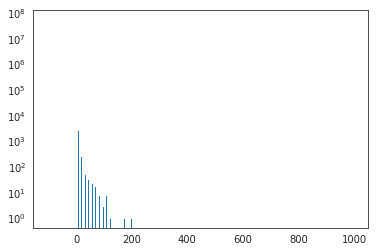

In [68]:
plt.hist(im250.flatten(),bins=np.arange(-100.0,1000.0,5.0));
plt.yscale('log')

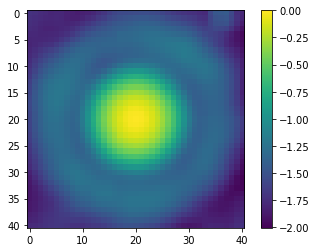

In [8]:
centre=np.long((MIPS_psf[1].header['NAXIS1']-1)/2)
radius=20

plt.imshow(np.log10(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1]/np.max(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1])))
plt.colorbar()

In [69]:
prior_cat = Table.read('data/data_release/xidplus_prior_cat_MIPS.fits')
MIPS_lower = prior_cat['MIPS_lower']
MIPS_upper = prior_cat['MIPS_upper']

In [70]:
len(prior_cat)

439803

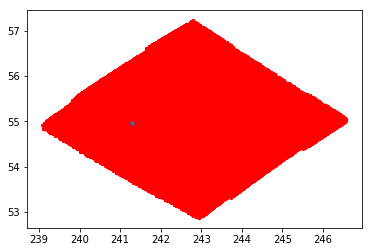

In [11]:
#x = help_masterlist['ra']
#y = help_masterlist['dec']
#plt.scatter(x,y,s=1)

x = prior_cat['ra']
y = prior_cat['dec']
plt.scatter(x,y,s=5,color='red')

x = ras
y = decs
plt.scatter(x,y,s=10)

#plt.xlim(np.min(help_masterlist['ra']),np.max(help_masterlist['ra']))
#plt.ylim(np.min(help_masterlist['dec']),np.max(help_masterlist['dec']))
plt.show()

In [71]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)  
import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,60,15)

In [73]:
#---prior250--------
t1 = time.time()
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
t2 = time.time()
print('time taken is: {}s'.format(t2-t1))

#prior250=xidplus.prior(MIPS_Map[1].data,MIPS_Map[2].data,MIPS_Map[0].header,MIPS_Map[1].header,moc=moc)
prior250.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',flux_lower=MIPS_lower,flux_upper=MIPS_upper,ID=prior_cat['help_id'])#Set input catalogue
prior250.prior_bkg(0.0,1)#Set prior on background (assumes Gaussian pdf with mu and sigma)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



time taken is: 380.9188253879547s


In [34]:
#for 1 source with 15" radius moc it took ~540s
#for 10 sources with 15" radius moc it took ~620s
#for 50 sources with 15" radius moc it took ~570s

In [74]:
centre=np.long((MIPS_psf[1].header['NAXIS1']-1)/2)
radius=20
prior250.set_prf(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1]/1.0E6,np.arange(0,41/2.0,0.5),np.arange(0,41/2.0,0.5))#requires PRF as 2d grid, and x and y bins for grid (in pixel scale)

In [75]:
print('fitting '+ str(prior250.nsrc)+' sources \n')
print('using ' +  str(prior250.snpix)+' pixels')



fitting 66 sources 

using 7806 pixels


In [76]:
prior250.get_pointing_matrix()

In [89]:
prior250.upper_lim_map()

In [90]:
from xidplus.stan_fit import MIPS,SPIRE
t1 = time.time()
fit=MIPS.MIPS_24(prior250,iter=2000)
t2 = time.time()
print('time taken is: {}s'.format(t2-t1))

/lustre/scratch/astro/im281/FIR-group/Ian/lofar/deep_fields/ELAIS-N1/XID+MIPS.pkl
/XID+MIPS found. Reusing
time taken is: 441.92146730422974s


In [78]:
#50 sources took ~120s

In [94]:
posterior=xidplus.posterior_stan(fit,[prior250])

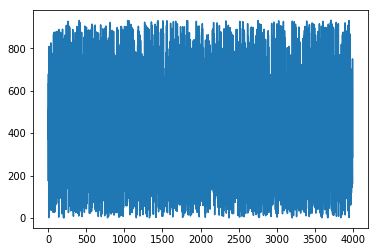

In [21]:
y = posterior.samples['src_f'][:,0,6]
plt.plot(np.arange(0,len(y)),y)

In [156]:
np.max(posterior.samples['src_f'])

320.93644271966235

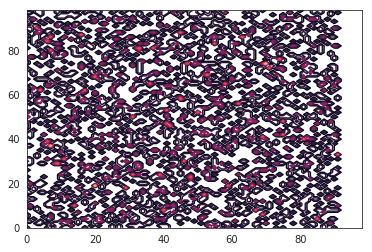

In [316]:
bins = np.arange(0,100,1)
data,_,_ = np.histogram2d(posterior.samples['src_f'][999:,0,3],posterior.samples['src_f'][999:,0,1],bins=bins)
#plt.imshow(data)
plt.contour(data)
plt.show()

In [95]:
priors = [prior250]

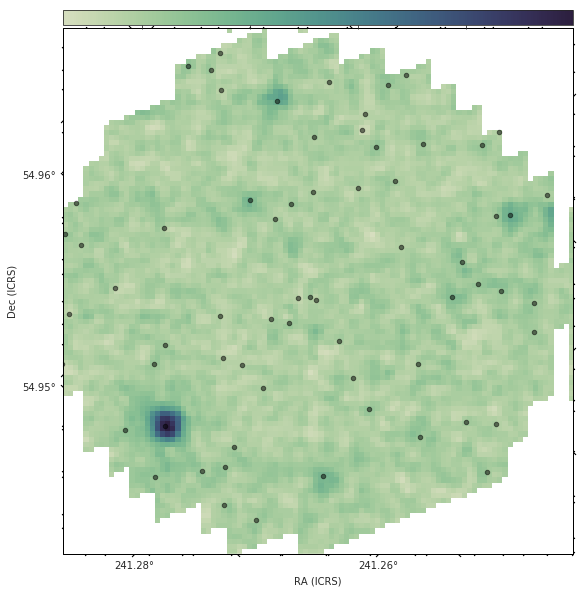

In [96]:
figs,fig=xidplus.plot_map(priors)

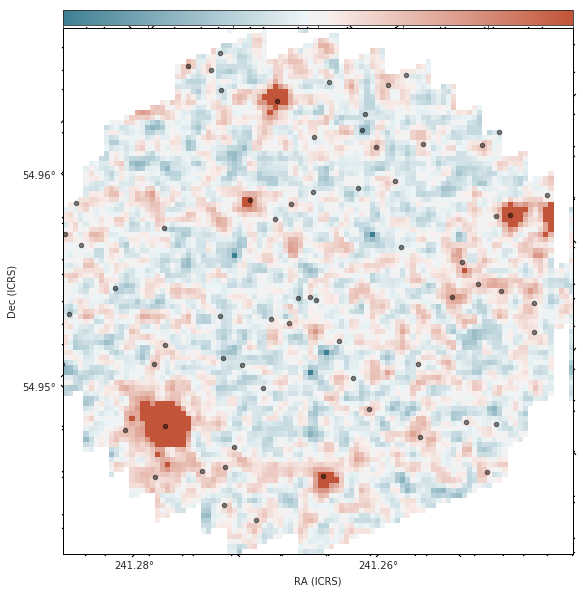

In [97]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)

In [98]:
import xidplus.catalogue as cat
MIPS_cat=cat.create_MIPS_cat(posterior,priors[0],0)

In [99]:
MIPS_cat = Table.read(MIPS_cat)

In [100]:
help_XID = Table.read('data/fir_MIPS_v10/dmu26_XID+MIPS_ELAIS-N1_SERVS_cat_20170725.fits')
joined = join(MIPS_cat,help_XID,join_type='inner',keys='help_id')
len(joined)

64

In [101]:
joined[:5]

help_id,RA_1,Dec_1,F_MIPS_24_1,FErr_MIPS_24_u_1,FErr_MIPS_24_l_1,Bkg_MIPS_24_1,Sig_conf_MIPS_24_1,Rhat_MIPS_24_1,n_eff_MIPS_24_1,Pval_res_24_1,RA_2,Dec_2,F_MIPS_24_2,FErr_MIPS_24_u_2,FErr_MIPS_24_l_2,Bkg_MIPS_24_2,Sig_conf_MIPS_24_2,Rhat_MIPS_24_2,n_eff_MIPS_24_2,Pval_res_24_2,flag_mips_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,,,,,,,,,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,bool
HELP_J160501.795+545754.712,241.25747962712734,54.9651977270931,1.0747086,1.7624071,0.36847493,-0.0036621073,5.0391855e-06,0.99931407,6199.8193,0.0,241.25747962712734,54.9651977270931,34.365112,49.244553,19.547272,-0.015399127,5.018918e-06,nan,1282.0,0.0,False
HELP_J160502.519+545804.332,241.26049480305701,54.9678699424993,0.85671216,1.6269135,0.2571569,-0.0036621073,5.0391855e-06,0.999884,6829.369,0.0,241.26049480305701,54.9678699424993,3.5995226,9.370305,0.93656087,-0.015399127,5.018918e-06,nan,2000.0,0.0,True
HELP_J160503.171+545759.680,241.26321221728634,54.96657769032303,0.9066912,1.6837221,0.2781419,-0.0036621073,5.0391855e-06,1.0000225,7937.745,0.0,241.26321221728634,54.96657769032303,3.9976716,10.023606,0.88965195,-0.015399127,5.018918e-06,nan,2000.0,0.0,True
HELP_J160503.519+545826.009,241.264662774057,54.973891433499304,1.0999377,1.7799183,0.37011522,-0.0036621073,5.0391855e-06,0.9998172,7066.409,0.0,241.264662774057,54.973891433499304,22.699932,37.19702,10.408235,-0.016803714,5.012366e-06,nan,2000.0,0.0,False
HELP_J160503.785+545749.579,241.26577228205701,54.963771912499304,1.3091044,1.8684311,0.59744036,-0.0036621073,5.0391855e-06,0.9997546,6983.2056,0.0,241.26577228205701,54.963771912499304,131.57991,145.63666,116.944664,-0.015399127,5.018918e-06,nan,2000.0,0.0,False


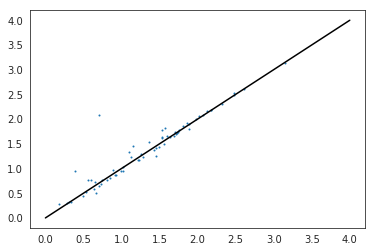

In [87]:
x = np.log10(joined['F_MIPS_24_2'])
xerr_u = np.log10(joined['FErr_MIPS_24_u_2']-joined['F_MIPS_24_2'])
yerr_l = np.log10(joined['F_MIPS_24_2']-joined['FErr_MIPS_24_l_2'])
y = np.log10(joined['F_MIPS_24_1'])
yerr_u = np.log10(joined['FErr_MIPS_24_u_1']-joined['F_MIPS_24_1'])
yerr_l = np.log10(joined['F_MIPS_24_1']-joined['FErr_MIPS_24_l_1'])

#plt.errorbar(x,y,xerr=xerr,yerr=[yerr_u,yerr_l],linestyle='')
plt.scatter(x,y,s=1)
plt.plot([0,4],[0,4],c='black')
plt.show()

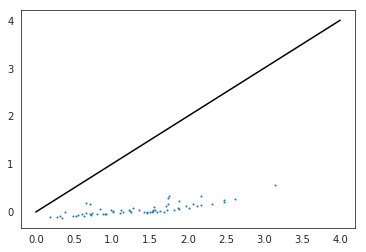

In [102]:
x = np.log10(joined['F_MIPS_24_2'])
xerr_u = np.log10(joined['FErr_MIPS_24_u_2']-joined['F_MIPS_24_2'])
yerr_l = np.log10(joined['F_MIPS_24_2']-joined['FErr_MIPS_24_l_2'])
y = np.log10(joined['F_MIPS_24_1'])
yerr_u = np.log10(joined['FErr_MIPS_24_u_1']-joined['F_MIPS_24_1'])
yerr_l = np.log10(joined['F_MIPS_24_1']-joined['FErr_MIPS_24_l_1'])

#plt.errorbar(x,y,xerr=xerr,yerr=[yerr_u,yerr_l],linestyle='')
plt.scatter(x,y,s=1)
plt.plot([0,4],[0,4],c='black')
plt.show()

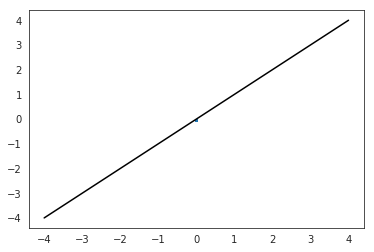

In [88]:
x = joined['Bkg_MIPS_24_2']
#xerr = np.log10(joined['ferr_mips_24'])
y = joined['Bkg_MIPS_24_1']


#plt.errorbar(x[::10],y[::10],xerr=xerr[::10],yerr=[yerr_u[::10],yerr_l[::10]],linestyle='')
plt.scatter(x,y,s=1)
plt.plot([-4,4],[-4,4],c='black')
plt.show()

In [67]:
mask = [MIPS_cat['help_id'][i] in ids for i in range(len(MIPS_cat))]
MIPS_cat[mask]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32
ILTJ155958.68+550534.6,239.9942929896559,55.0930282279941,90.73344,145.95277,30.674541,2.737582,4.8642487e-06,0.9985452,3958.191,0.0


In [140]:
mask = 'ILTJ' in SPIRE_cat['HELP_ID']
mask_lofar = lofar['ra']==ra
mask_pcat = prior_cat['help_id']=='lofar'
SPIRE_cat = SPIRE_cat[mask]
SPIRE_cat.add_columns([prior_cat['f_mips_24'][mask_pcat],prior_cat['flag_optnir_det'][mask_pcat]])
lofar_fir = hstack([lofar[mask_lofar],SPIRE_cat])
XID_rerun_col = Column(data=XID_rerun,name='XID_rerun',dtype=bool)
source_type_col = Column(data=source_type,name='source_type',dtype=str)
lofar_fir.add_columns([XID_rerun_col,source_type_col])
    
#os.mkdir('testfolder')
#Table.write(lofar_fir,'testfolder/lofar_xidplus_fir.fits')

In [72]:
Table.write(MIPS_cat,'data/fir_MIPS_v10/MIPS_rerun_test_60arcseconds_66_sources_upperlimit.fits')

xidplus.save([prior250],posterior,'data/fir_MIPS_v10/MIPS_rerun_test_60arcseconds_66_sources_upperlimit')

## Compare the results from the different runs and teh roiginal HELP run

In [310]:
run_15 = Table.read('data/fir_MIPS_v10/MIPS_rerun_test_15arcseconds_5_sources.fits')
run_30 = Table.read('data/fir_MIPS_v10/MIPS_rerun_test_30arcseconds_22_sources.fits')
run_60 = Table.read('data/fir_MIPS_v10/MIPS_rerun_test_60arcseconds_89_sources.fits')
run_60_bkg_0 = Table.read('data/fir_MIPS_v10/MIPS_rerun_test_60arcseconds_89_sources_bkg_0.fits')

In [287]:
run_15[0]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J160449.989+545545.943,241.208286902057,54.9294286024993,49.360302,82.606415,16.291082,-6.523287,4.9140804e-06,0.9996028,6582.0483,0.0


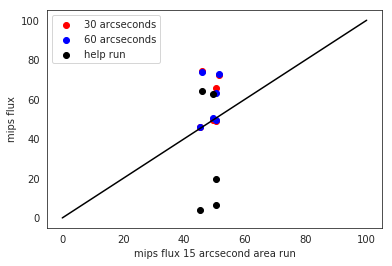

In [300]:
ids = run_15['help_id']
mask = np.array([name in ids for name in run_30['help_id']])
x = run_15['F_MIPS_24']
y = run_30['F_MIPS_24'][mask]
plt.scatter(x,y,c='red',label='30 arcseconds')

ids = run_15['help_id']
mask = np.array([name in ids for name in run_60['help_id']])
x = run_15['F_MIPS_24']
y = run_60['F_MIPS_24'][mask]
plt.scatter(x,y,c='blue',label='60 arcseconds')

tmp = join(run_15,help_XID,join_type='inner',keys='help_id')
x = tmp['F_MIPS_24_1']
y = tmp['F_MIPS_24_2']
plt.scatter(x,y,c='black',label='help run')

plt.plot([0,100],[0,100],c='black')
plt.xlabel('mips flux 15 arcsecond area run')
plt.ylabel('mips flux')
plt.legend()
plt.show()

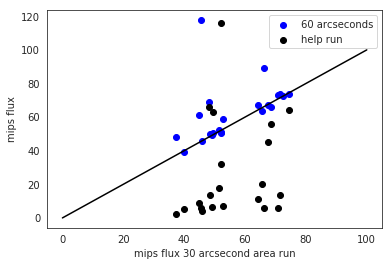

In [301]:
ids = run_30['help_id']
mask = np.array([name in ids for name in run_60['help_id']])
x = run_30['F_MIPS_24']
y = run_60['F_MIPS_24'][mask]
plt.scatter(x,y,c='blue',label='60 arcseconds')

tmp = join(run_30,help_XID,join_type='inner',keys='help_id')
x = tmp['F_MIPS_24_1']
y = tmp['F_MIPS_24_2']
plt.scatter(x,y,c='black',label='help run')

plt.plot([0,100],[0,100],c='black')
plt.xlabel('mips flux 30 arcsecond area run')
plt.ylabel('mips flux')
plt.legend()
plt.show()

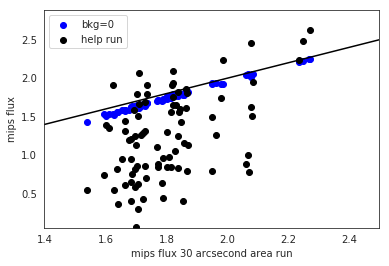

In [311]:
x = np.log10(run_60['F_MIPS_24'])
y = np.log10(run_60_bkg_0['F_MIPS_24'])
plt.scatter(x,y,c='blue',label='bkg=0')

tmp = join(run_60,help_XID,join_type='inner',keys='help_id')
x = np.log10(tmp['F_MIPS_24_1'])
y = np.log10(tmp['F_MIPS_24_2'])
plt.scatter(x,y,c='black',label='help run')

plt.plot([0,3],[0,3],c='black')

plt.xlim(np.min(x)/1.1,np.max(x)*1.1)
plt.ylim(np.min(y)/1.1,np.max(y)*1.1)
plt.xlabel('mips flux 30 arcsecond area run')
plt.ylabel('mips flux')
plt.legend()
plt.show()